# Multidimensional Regression on LHC collision jets Submission

Add your solution below!

To run the notebook in VS Code, you can click on the `Run All` button in the toolbar. You may need to select the kernel to run. When prompted select `Python Environments` and then `.venv` (Should be starred).

> Note: You can add dependencies to your virtual environment by running `aqora add <dependency name>` or editing the `pyproject.toml` at the root of the project

Once you're ready, you can open a terminal by clicking `Terminal` and then `New Terminal` in the context bar at the very top. To test your solution, run

```bash
aqora test
```

Finally, once all the tests are passing, to submit to **Aqora** run

```bash
aqora upload
```


## libraries

In [122]:
import h5py
from vector import Vector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [123]:
base_path = os.getcwd()
data_path = base_path.replace('submission', 'data')
output_path = base_path.replace('submission', 'datasets')
partons_fp =f'{data_path}/pp-z-to-jets-500K-54167.h5'
jets_partons_fp = f'{data_path}/pp-z-to-jets-500K-57246.h5' 
print(jets_partons_fp)
print(partons_fp)

/Users/gouthamarcot/Documents/personal/codebase/Quantum_Agoize/HEP-Regression/data/pp-z-to-jets-500K-57246.h5
/Users/gouthamarcot/Documents/personal/codebase/Quantum_Agoize/HEP-Regression/data/pp-z-to-jets-500K-54167.h5


Custom LorentzVectors just a test

In [124]:
class LorentzVector:
    def __init__(self, px, py, pz, E):
        self.px = px
        self.py = py
        self.pz = pz
        self.E = E
    # transverse momementum
    def pt(self):
        return np.sqrt(self.px**2 + self.py**2)
    # pseudorapidity 
    def eta(self):
        p = np.sqrt(self.px**2 + self.py**2 + self.pz**2)
        return 0.5 * np.log((p + self.pz) / (p - self.pz))

    def phi(self):
        return np.arctan2(self.py, self.px)
    
    def inv_mass(self):
        return np.sqrt(self.E - self.px**2 + self.py**2 + self.pz**2)

In [125]:
def compute_derived_quantities_partons(df):
        results = []
        for index, row in df.iterrows():
            parton_1 = LorentzVector(px=row['parton_0_px'], py=row['parton_0_py'], pz=row['parton_0_pz'], E=row['parton_0_E'])
            parton_2 = LorentzVector(px=row['parton_1_px'], py=row['parton_1_py'], pz=row['parton_1_pz'], E=row['parton_1_E'])
            pt_1 = parton_1.pt()
            pt_2 = parton_2.pt()
            eta_1 = parton_1.eta()
            eta_2 = parton_2.eta()
            phi_1 = parton_1.phi()
            phi_2 = parton_2.phi()
            delta_r = compute_delta_r(eta_1, phi_1, eta_2, phi_2)
            results.append({
                'event_id': index,
                'parton_0_pt': pt_1,
                'parton_1_pt': pt_2,
                'parton_0_eta': eta_1,
                'parton_1_eta': eta_2,
                'parton_0_phi': phi_1,
                'parton_1_phi': phi_2,
                'delta_r': delta_r
            })
        res = pd.DataFrame(results)
        return res


In [126]:
def compute_derived_quantities_jets(df, num_max_jets):
        results = []
        for index, row in df.iterrows():
            jet_data = []
            for j in range(num_max_jets):
                if row[f'jet_{j}_px'] == 0 and row[f'jet_{j}_py'] == 0 and row[f'jet_{j}_pz'] == 0 and row[f'jet_{j}_E'] == 0:
                    continue 
                jet = LorentzVector(px=row[f'jet_{j}_px'], py=row[f'jet_{j}_py'], pz=row[f'jet_{j}_pz'], E=row[f'jet_{j}_E'])
                jet_data.append({
                    f'jet_{j}_pt': jet.pt(),
                    f'jet_{j}_eta': jet.eta(),
                    f'jet_{j}_phi': jet.phi()
                })
            results.append({'event_id': index, **{k: v for d in jet_data for k, v in d.items()}})

        return pd.DataFrame(results)

## Parton jets relationship 

#### added to determing the relationship between the parton events and their respective jets

In [127]:
def analyze_parton_jet_relationship_to_csv(merged_df):
    merged_df['pt_diff_0'] = merged_df['parton_0_pt'] - merged_df['jet_0_pt']
    merged_df['pt_ratio_0'] = merged_df['parton_0_pt'] / merged_df['jet_0_pt']
    merged_df['eta_diff_0'] = merged_df['parton_0_eta'] - merged_df['jet_0_eta']
    merged_df['phi_diff_0'] = merged_df['parton_0_phi'] - merged_df['jet_0_phi']

    merged_df['pt_diff_1'] = merged_df['parton_1_pt'] - merged_df['jet_1_pt']
    merged_df['pt_ratio_1'] = merged_df['parton_1_pt'] / merged_df['jet_1_pt']
    merged_df['eta_diff_1'] = merged_df['parton_1_eta'] - merged_df['jet_1_eta']
    merged_df['phi_diff_1'] = merged_df['parton_1_phi'] - merged_df['jet_1_phi']
    merged_df.to_csv(f"{output_path}/parton_jet_relationships.csv")
    print("Parton-Jet Relationship DataFrame:")

In [128]:
def analyze_parton_jet_relationship(merged_df):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(merged_df['parton_0_pt'], merged_df['jet_0_pt'], alpha=0.5, label='Parton 0 vs Jet 0')
    plt.xlabel('Parton 1 pT')
    plt.ylabel('Leading Jet pT')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.scatter(merged_df['parton_1_pt'], merged_df['jet_1_pt'], alpha=0.5, label='Parton 1 vs Jet 1')
    plt.xlabel('Parton 2 pT')
    plt.ylabel('Subleading Jet pT')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [129]:
def process_hep_data(file_path):
    with h5py.File(file_path, 'r') as f:
        print(f"Processing {file_path}")
        data_file_name = file_path.split('/')[-1]
        data_file = data_file_name.split('-')[-1]
        print(f'Keys {f.keys()}')
        if 'partons' in f and 'jets' in f:
            print(f"Processing partons and jets {data_file}")
            partons_data = f['partons'][:]
            column_names = [f'parton_{i}_{component}' for i in range(partons_data.shape[1]) for component in ['px', 'py', 'pz', 'E', 'id', 'charge']]
            partons_df = pd.DataFrame(partons_data.reshape(partons_data.shape[0], -1), columns=column_names)
            partons_derived_df = compute_derived_quantities_partons(partons_df)
            partons_df['event_id'] = np.arange(partons_data.shape[0])
            partons_df = pd.merge(partons_df, partons_derived_df, on='event_id')
            partons_df.to_csv(f"{output_path}/{data_file}_partons_df.csv")
            print("Partons DataFrame with Derived Quantities: exported")
            jets_data = f['jets'][:]
            num_max_jets = jets_data.shape[1]
            jet_column_names = [f'jet_{j}_{component}' for j in range(num_max_jets) for component in ['px', 'py', 'pz', 'E']]
            jets_df = pd.DataFrame(jets_data.reshape(jets_data.shape[0], -1), columns=jet_column_names)
            jets_derived_df = compute_derived_quantities_jets(jets_df, num_max_jets)
            jets_df['event_id'] = np.arange(jets_df.shape[0])
            jets_df = pd.merge(jets_df, jets_derived_df, on='event_id')
            jets_df.to_csv(f"{output_path}/{data_file}_jets_df.csv")
            print("Jets DataFrame with Derived Quantities: exported")
            merged_df = pd.merge(partons_df, jets_df, on='event_id')
            analyze_parton_jet_relationship(merged_df)
            analyze_parton_jet_relationship_to_csv(merged_df)
        elif 'partons' in f:
            print(f"Processing partons {data_file}")
            partons_data = f['partons'][:]
            column_names = [f'parton_{i}_{component}' for i in range(partons_data.shape[1]) for component in ['px', 'py', 'pz', 'E', 'id', 'charge']]
            partons_df = pd.DataFrame(partons_data.reshape(partons_data.shape[0], -1), columns=column_names)
            partons_derived_df = compute_derived_quantities_partons(partons_df)
            partons_df['event_id'] = np.arange(partons_data.shape[0])
            partons_df = pd.merge(partons_df, partons_derived_df, on='event_id')
            partons_df.to_csv(f"{output_path}/{data_file}_partons_df.csv")
            print("Partons DataFrame with Derived Quantities:")
        elif 'jets' in f:
            print(f"Processing jets {data_file}")
            jets_data = f['jets'][:]
            num_max_jets = jets_data.shape[1]
            jet_column_names = [f'jet_{j}_{component}' for j in range(num_max_jets) for component in ['px', 'py', 'pz', 'E']]
            jets_df = pd.DataFrame(jets_data.reshape(jets_data.shape[0], -1), columns=jet_column_names)
            jets_derived_df = compute_derived_quantities_jets(jets_df, num_max_jets)
            jets_df['event_id'] = np.arange(jets_df.shape[0])
            jets_df = pd.merge(jets_df, jets_derived_df, on='event_id')
            jets_df.to_csv(f"{output_path}/{data_file}_jets_df.csv")
            print("Jets DataFrame with Derived Quantities:")
        else:
            print("Neither 'partons' nor 'jets' dataset found in the file.")


In [130]:
def compute_delta_r(eta1, phi1, eta2, phi2):
    delta_eta = eta1 - eta2
    delta_phi = phi1 - phi2
    delta_phi = (delta_phi + np.pi) % (2 * np.pi) - np.pi
    delta_r = np.sqrt(delta_eta**2 + delta_phi**2)
    return delta_r

## partons-jets (parton-level) data

In [131]:
process_hep_data(partons_fp)

Processing /Users/gouthamarcot/Documents/personal/codebase/Quantum_Agoize/HEP-Regression/data/pp-z-to-jets-500K-54167.h5
Keys <KeysViewHDF5 ['partons']>
Processing partons 54167.h5
Partons DataFrame with Derived Quantities:


Processing /Users/gouthamarcot/Documents/personal/codebase/Quantum_Agoize/HEP-Regression/data/pp-z-to-jets-500K-57246.h5
Keys <KeysViewHDF5 ['jets', 'partons']>
Processing partons and jets 57246.h5
Partons DataFrame with Derived Quantities: exported
Jets DataFrame with Derived Quantities: exported


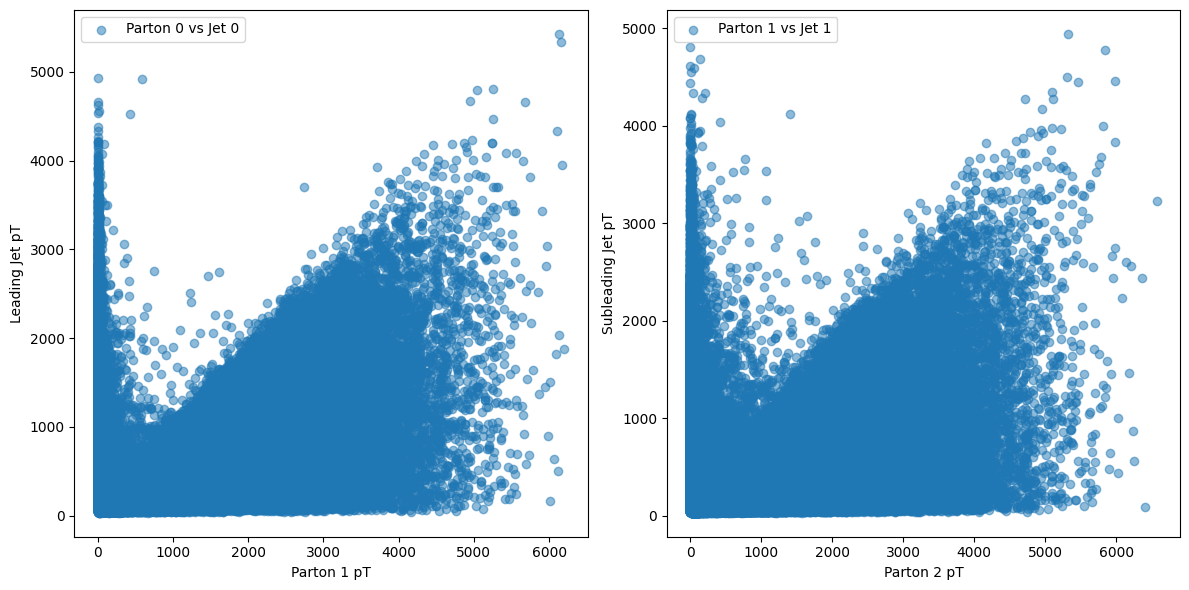

Parton-Jet Relationship DataFrame:


In [132]:
process_hep_data(jets_partons_fp)

### Data Verfiication for jet : partons


In [133]:
import numpy as np
import pandas as pd

rng = np.random.default_rng()

solution = pd.DataFrame({
    "EventID": np.arange(0, n_events),
    "n_jets_pred": rng.integers(low=0, high=10, size=n_events),
    "leading_pt_pred": rng.uniform(low=30, high=130, size=n_events),
    "subleading_pt_pred": rng.uniform(low=30, high=130, size=n_events),
})

NameError: name 'n_events' is not defined

In [ ]:
import io

output = io.StringIO()
solution.to_csv(output)
output = output.getvalue()